## Vehicle Detection Project

The goals / steps of this project are the following:

* Extract and combine features of a image
* Build a classifier to classify car
* Implement sliding window to detect car
* Use heat map to build and draw the bounding box of the cars

---

### 0. Preprocess

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import pickle
import time
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from subprocess import call
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label
%matplotlib inline

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### 1. Extract Features

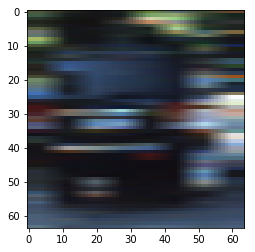

In [4]:
# just some random experiment
image = mpimg.imread('vehicles/KITTI_extracted/370.png')
plt.imshow(cv2.resize(cv2.resize(image, (8,64)), (64,64)), cmap='gray')

(1764,)


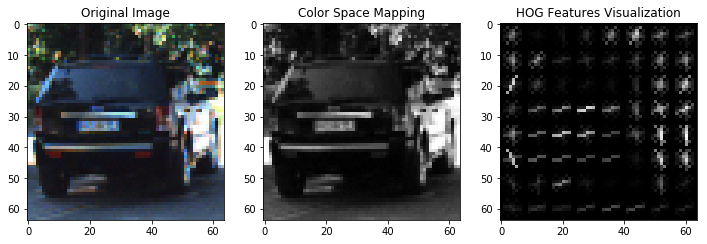

In [27]:
def extract_image_feature(img, debug=False):
    color_mapped = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)[:,:,2]
    
    if debug:
        features, hog_image = get_hog_features(color_mapped, 9, 8, 2, vis=True)
    else:
        features = get_hog_features(color_mapped, 9, 8, 2, vis=False)    
        
    if debug:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
        ax1.imshow(img)
        ax1.set_title('Original Image')
        ax2.imshow(color_mapped, cmap='gray')
        ax2.set_title('Color Space Mapping')
        ax3.imshow(hog_image, cmap='gray')
        ax3.set_title('HOG Features Visualization')
    
    return features
    

image = mpimg.imread('vehicles/KITTI_extracted/370.png')
features = extract_image_feature(image, True)
print (features.shape)

### 2. Build Classifier

In [6]:
def get_train_test_data():
    # import data and generate features X , labels y
    vehicle_paths = glob.glob('vehicles/*/*')#[0:100]
    nonvehicle_paths = glob.glob('non-vehicles/*/*')#[0:100]
    
    car_features = []
    notcar_features = []
    
    for path in tqdm(vehicle_paths,    desc='Extracting car image feature     '):
        car_features.append(extract_image_feature(mpimg.imread(path)))
    
    for path in tqdm(nonvehicle_paths, desc='Extracting non-car image feature '):
        notcar_features.append(extract_image_feature(mpimg.imread(path)))

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test, X_scaler


def train_model(X_train, X_test, y_train, y_test, X_scaler):
    print ('Training model ...')
    #model = LinearSVC(verbose=True)
    model = SVC(verbose=True)
    model.fit(X_train, y_train)
    print()
    print ('Model training done, calculating accuracy ...')
    accuracy = accuracy_score(model.predict(X_test), y_test)
    print ('Accuracy: ' + str(accuracy))
    return model, X_scaler

In [7]:
X_train, X_test, y_train, y_test, X_scaler = get_train_test_data()

Extracting non-car image feature : 100%|██████████| 8968/8968 [00:24<00:00, 368.99it/s]


In [8]:
model, X_scaler = train_model(X_train, X_test, y_train, y_test, X_scaler)

Training model ...
[LibSVM]
Model training done, calculating accuracy ...
Accuracy: 0.990990990991


### 3. Sliding Window

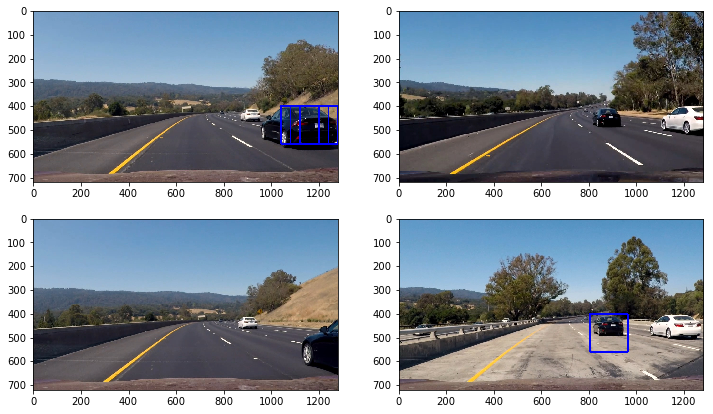

In [9]:
def find_cars(img, ystart, ystop, scale, model, X_scaler, orient, pix_per_cell, cell_per_block, box_list = [], debug=False):
    if ystop <= 0:
        ystop = ystart + np.ceil(scale * 64).astype(int)
    if debug:
        draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1))
            
            test_prediction = model.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                if debug:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    if debug:
        return box_list, draw_img
    else:
        return box_list
    
def find_cars_allscale(img, model, X_scaler, debug=False):
    if (debug):
        box_list, out_img = find_cars(img, ystart=400, ystop=-1, scale=2.5, model=model, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, debug=debug)
        plt.imshow(out_img)
    else:
        box_list = []
        box_list = find_cars(img, ystart=400, ystop=-1, scale=1.3, model=model, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, box_list=box_list)
        box_list = find_cars(img, ystart=400, ystop=-1, scale=1.9, model=model, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, box_list=box_list)
        box_list = find_cars(img, ystart=400, ystop=-1, scale=2.5, model=model, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, box_list=box_list)
        box_list = find_cars(img, ystart=400, ystop=-1, scale=3.6, model=model, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, box_list=box_list)
    return box_list




fig = plt.figure(figsize = (12,7))
plt.subplot(221)
find_cars_allscale(mpimg.imread('test_images/mytest1.jpg'), model, X_scaler, True)
plt.subplot(222)
find_cars_allscale(mpimg.imread('test_images/mytest2.jpg'), model, X_scaler, True)
plt.subplot(223)
find_cars_allscale(mpimg.imread('test_images/mytest3.jpg'), model, X_scaler, True)
plt.subplot(224)
find_cars_allscale(mpimg.imread('test_images/test1.jpg'), model, X_scaler, True)

box_list = find_cars_allscale(mpimg.imread('test_images/test1.jpg'), model, X_scaler)

### 4. Heat Map & Drawing

[((832, 400), (915, 483)), ((852, 400), (935, 483)), ((1164, 400), (1247, 483)), ((820, 400), (941, 521)), ((851, 400), (972, 521)), ((1064, 400), (1185, 521)), ((1124, 400), (1245, 521)), ((800, 400), (960, 560))]


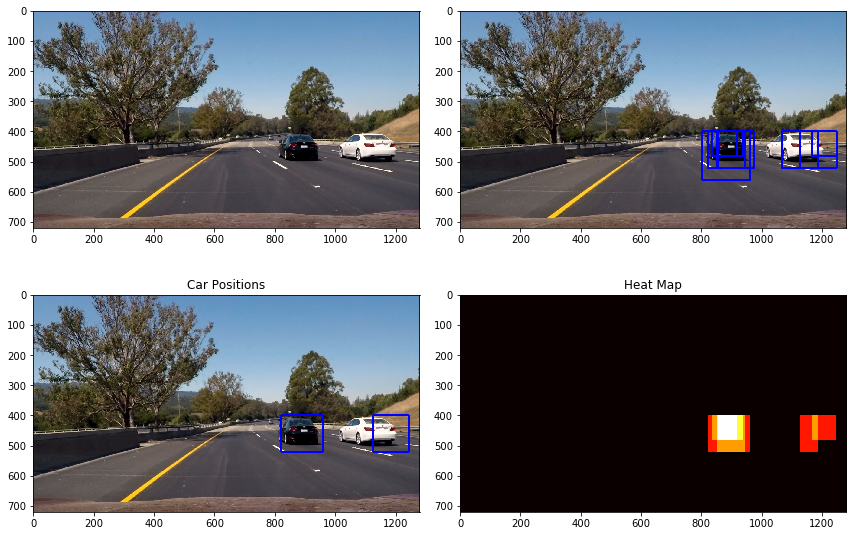

In [20]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 25

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def generate_heatmap_boxes(image, box_list, heatmap_memory, debug = False):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)
    
    if len(heatmap_memory) != 0:
        last_heat = heatmap_memory[0]
        last_heat = cv2.GaussianBlur(last_heat,(11,11),0)
        last_heat -= 15
        heat = last_heat + heat
        heat = np.clip(heat, 0, 255)
        heatmap_memory[0] = heat
        heatmap = apply_threshold(heat,74)
    else:
        heat = np.clip(heat, 0, 255)
        heatmap_memory.append(heat)
        heatmap = apply_threshold(heat,45)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    if debug:
        fig = plt.figure(figsize = (12,8))
        plt.subplot(221)
        plt.imshow(image)
        plt.subplot(222)
        allbox_image = np.copy(image)
        for b in box_list:
            cv2.rectangle(allbox_image,b[0], b[1],(0,0,255),6) 
        plt.imshow(allbox_image)
        plt.subplot(223)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(224)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
    
    return np.clip(np.dstack((heat,heat*0.5,np.zeros_like(heat))).astype(np.int) + image.astype(np.int)//2, 0, 255).astype(np.uint8)
    #return draw_img
    
print (box_list)
di = generate_heatmap_boxes(mpimg.imread('test_images/test6.jpg'), box_list, [], debug=True)

### 5. Video Output

In [12]:
heatmap_memory = []

def processFrame(frame):
    box_list = find_cars_allscale(frame, model, X_scaler)
    frame = generate_heatmap_boxes(frame, box_list, heatmap_memory)
    return frame

In [13]:
import lanefinding

frameLaneInfo = None
ret, mtx, dist, rvecs, tvecs = lanefinding.calibrate()
heatmap_memory = []

def processFrameBoth(frame):
    box_list = find_cars_allscale(frame, model, X_scaler)
    
    frame = lanefinding.distortionCorrection(frame, ret, mtx, dist, rvecs, tvecs)
    canvas = lanefinding.thresholdMask(frame)
    canvas = lanefinding.birdsEyeViewWarp(canvas)
    lanefinding.findLane(canvas, frameLaneInfo)
    canvas = lanefinding.overlayImg(frame, frameLaneInfo)
    canvas = lanefinding.addText(canvas, 0.5*(frameLaneInfo.left_curverad + frameLaneInfo.right_curverad), frameLaneInfo.vehicle_position)
    
    canvas = generate_heatmap_boxes(canvas, box_list, heatmap_memory)
    
    return canvas


In [21]:
clip = VideoFileClip("project_video.mp4").subclip(30, 50)
heatmap_memory = []
frameLaneInfo = lanefinding.LaneInfo()
out_clip = clip.fl_image(processFrame)
%time out_clip.write_videofile('heatmap2.mp4', audio=False)
call(["say", "Video processing finished!"])

[MoviePy] >>>> Building video heatmap2.mp4
[MoviePy] Writing video heatmap2.mp4


100%|█████████▉| 500/501 [10:51<00:01,  1.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: heatmap2.mp4 

CPU times: user 9min 18s, sys: 39 s, total: 9min 57s
Wall time: 10min 52s


0

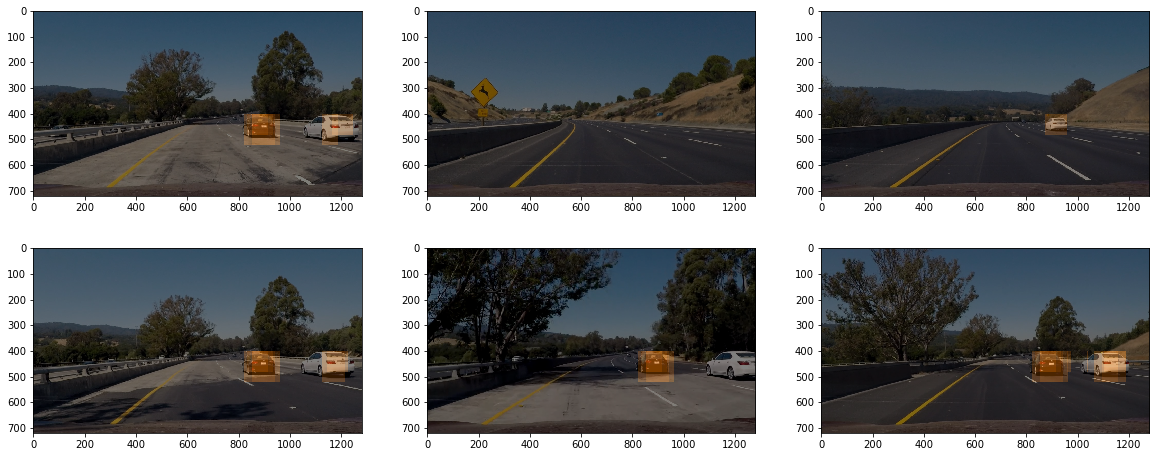

In [22]:
plt.figure(figsize=(20,8))
for i in range(6):
    img = mpimg.imread('test_images/test{}.jpg'.format(i+1))
    
    heatmap_memory = []
    img = processFrame(img)
    
    plt.subplot(2,3,i+1)
    plt.imshow(img)